## Charger les donnée depuis Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("greg115/abstract-art")

print("Path to dataset files:", path)

100%|██████████| 296M/296M [00:02<00:00, 111MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/greg115/abstract-art/versions/1


## Bibiothèques

In [ ]:
import cv2
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, utils
from tensorflow.keras import backend as K
from pathlib import Path
from typing import Optional, Tuple, List
from PIL import Image

In [ ]:
def trie_image(path):
    img = cv2.imread(path)
    if img is None: return None

    # Conversion BGR vers HSV pour mieux analyser les couleurs
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mean_h = np.mean(hsv[:, :, 0]) # Teinte
    mean_s = np.mean(hsv[:, :, 1]) # Saturation
    mean_v = np.mean(hsv[:, :, 2]) # Luminosité

    # Classification par luminosité
    if mean_v < 80:
         return "Sombre"
    elif mean_v > 180:
      return "Lumineux"

    # Classification par saturation
    if mean_s < 40: return "Neutre"

    # Classification par teinte
    # ERouge 0-10 et 170-180, Jaune 20-30, Bleu 100-120
    if (0 <= mean_h < 60) or (150 < mean_h <= 180):
        return "Chaud" # Rouges, Oranges, Jaunes
    elif 60 <= mean_h < 150:
        return "Végétal" # Verts / Jaune-Vert
    elif 150 <= mean_h < 180:
        return "Froid" # Bleus, Violets, Cyans
    else:
        return "Autre"

# Utilisation
source_folder = path
output_base = "data/dataset_trie"

# Créer les dossiers
categories = ["Chaud", "Froid", "Lumineux", "Neutre", "Sombre", "Végétal", "Autre"]
for cat in categories:
    os.makedirs(os.path.join(output_base, cat), exist_ok=True)

# Boucle de tri
for root, dirs, files in os.walk(source_folder):
    for filename in files:
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            src = os.path.join(root, filename)

            mood = trie_image(src)
            if mood:
                dst = os.path.join(output_base, mood, filename)
                shutil.copy2(src, dst)
                print(f"Image {filename} classée dans : {mood}")

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
Image abstract_patrick-heron_5842.jpg classée dans : Lumineux
Image abstract_max-bill_1598.jpg classée dans : Chaud
Image abstract_enrico-castellani_2527.jpg classée dans : Lumineux
Image abstract_carla-accardi_171.jpg classée dans : Lumineux
Image abstract_sam-francis_4642.jpg classée dans : Chaud
Image abstract_jacob-kassay_6679.jpg classée dans : Neutre
Image abstract_morris-graves_5363.jpg classée dans : Neutre
Image abstract_yves-klein_6948.jpg classée dans : Chaud
Image abstract_alberto-biasi_1557.jpg classée dans : Lumineux
Image abstract_verena-loewensberg_7820.jpg classée dans : Lumineux
Image abstract_anni-albers_276.jpg classée dans : Chaud
Image abstract_adolf-fleischmann_4548.jpg classée dans : Végétal
Image abstract_bram-bogart_1837.jpg classée dans : Lumineux
Image abstract_tony-delap_3509.jpg classée dans : Lumineux
Image abstract_roman-cotosman_2946.jpg classée dans : Neutre
Image abstract_eu

Représentation des données

### Configurations

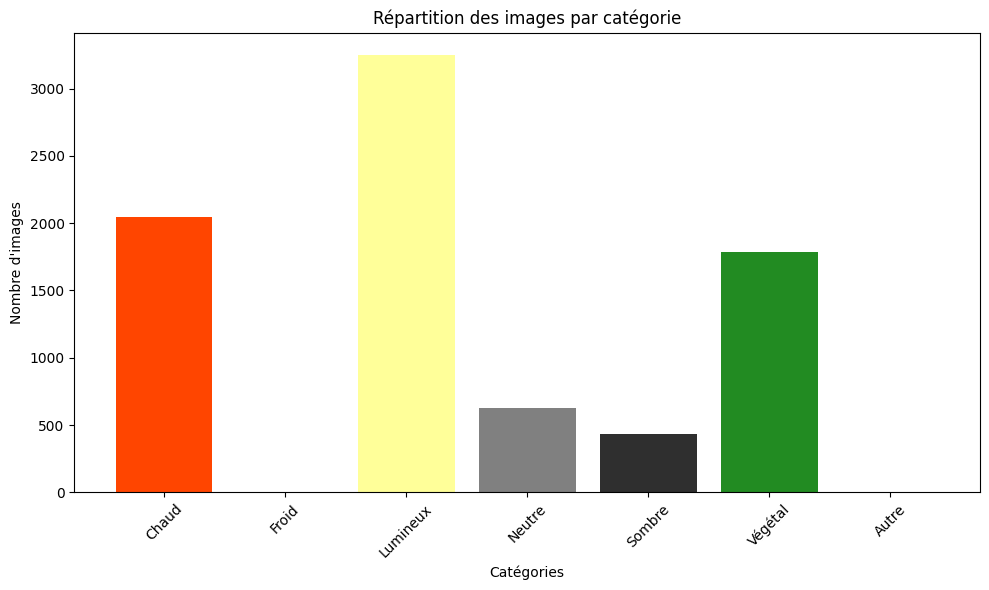

In [ ]:
# Calculer les statistiques
stats = {}
for cat in categories:
    cat_path = os.path.join(output_base, cat)
    count = len([f for f in os.listdir(cat_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    stats[cat] = count

# Couleurs représentatives de chaque catégorie
couleurs_categories = {
    'Chaud': '#FF4500',      # Rouge-orangé
    'Froid': '#1E90FF',      # Bleu
    'Sombre': '#2F2F2F',     # Gris très foncé
    'Lumineux': '#FFFF99',   # Jaune clair
    'Végétal': '#228B22',    # Vert
    'Neutre': '#808080',     # Gris
    'Autre': '#A9A9A9'       # Gris moyen
}

colors = [couleurs_categories.get(cat, '#000000') for cat in stats.keys()]

# Graphique en barres verticales
plt.figure(figsize=(10, 6))
#colors = ['#FF5733', '#3498DB', '#2C3E50', '#F1C40F', '#27AE60', '#9B59B6', '#95A5A6']
plt.bar(stats.keys(), stats.values(), color=colors)
plt.xlabel('Catégories')
plt.ylabel('Nombre d\'images')
plt.title('Répartition des images par catégorie')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
IMAGES_DIR = "data/dataset_trie"
IMAGE_SIZE = 128
BATCH_SIZE = 64
LATENT_DIM = 128   # Plus d'espace pour plus de détails
EPOCHS = 100
LEARNING_RATE = 0.0005

### Création des datasets TensorFlow

In [34]:
dataset = tf.keras.utils.image_dataset_from_directory(
    IMAGES_DIR,
    label_mode="categorical",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42
)


class_names = dataset.class_names
NUM_CLASSES = len(class_names)

print("Classes :", class_names)

Found 8145 files belonging to 7 classes.
Classes : ['Autre', 'Chaud', 'Froid', 'Lumineux', 'Neutre', 'Sombre', 'Végétal']


In [35]:
def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

train_dataset = dataset.map(preprocess).prefetch(tf.data.AUTOTUNE)

## Bloc convolution

In [36]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = K.random_normal(shape=K.shape(z_mean))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

# ENCODEUR
img_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
label_input = layers.Input(shape=(NUM_CLASSES,))

# image + label
label_reshaped = layers.Reshape((1, 1, NUM_CLASSES))(label_input)
label_tiled = layers.Lambda(lambda x: K.tile(x, [1, IMAGE_SIZE, IMAGE_SIZE, 1]))(label_reshaped)
x = layers.Concatenate()([img_input, label_tiled])

for filters in [32, 64, 128]:
    x = layers.Conv2D(filters, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

shape_before_flatten = K.int_shape(x)[1:]
x = layers.Flatten()(x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = models.Model([img_input, label_input], [z_mean, z_log_var, z], name="encoder")

# DÉCODEUR
z_input = layers.Input(shape=(LATENT_DIM,))
x = layers.Concatenate()([z_input, label_input])
x = layers.Dense(np.prod(shape_before_flatten))(x)
x = layers.Reshape(shape_before_flatten)(x)

for filters in [128, 64, 32]:
    x = layers.Conv2DTranspose(filters, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)

decoder_output = layers.Conv2DTranspose(3, 3, padding="same", activation="sigmoid")(x)
decoder = models.Model([z_input, label_input], decoder_output, name="decoder")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Construction du VAE (Auto Encodeur varaitionel)

In [39]:
class CVAE_Model(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        img, labels = data
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([img, labels])
            reconstruction = self.decoder([z, labels])

            # Reconstruction Loss (MSE est souvent plus stable pour l'art)
            reco_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.mse(img, reconstruction), axis=(1, 2)))

            # KL Loss pondérée (Beta-VAE)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))

            BETA = 0.0005
            total_loss = reco_loss + (BETA * kl_loss)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {"loss": total_loss, "reco": reco_loss, "kl": kl_loss}

In [40]:
cvae = CVAE_Model(encoder, decoder)
cvae.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE))
cvae.fit(train_dataset, epochs=EPOCHS)

Epoch 1/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 124ms/step - kl: 3655.4885 - loss: 894.0493 - reco: 892.2215
Epoch 2/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - kl: 630.0563 - loss: 562.0282 - reco: 561.7132
Epoch 3/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - kl: 659.0430 - loss: 457.7778 - reco: 457.4483
Epoch 4/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - kl: 666.0562 - loss: 404.1649 - reco: 403.8318
Epoch 5/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - kl: 672.5089 - loss: 372.0665 - reco: 371.7302
Epoch 6/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - kl: 666.0623 - loss: 348.6478 - reco: 348.3148
Epoch 7/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - kl: 679.0462 - loss: 333.2533 - reco: 332.9138
Epoch 8/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 85ms/step - kl: 678.0883 - loss: 311.8914 - reco: 311.5523
Epoch 9/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - kl: 689.1414 - loss: 297.9846 - reco: 297.6400
Epoch 10/100
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 86ms/step - kl: 

## Génération des Gifs

In [41]:

def creer_gif_exploration(cvae, amb, class_names,
                         n_frames=120, radius=2.0,
                         duration=50,
                         output='exploration.gif'):

    idx = class_names.index(amb)

    labels = np.zeros((1, NUM_CLASSES))
    labels[0, idx] = 1
    labels = labels.astype(np.float32)

    frames = []

    # Point central dans l'espace latent
    z_center = np.random.normal(size=(1, LATENT_DIM)).astype(np.float32)

    # Créer un cercle dans l'espace latent
    for i in range(n_frames):
        angle = 2 * np.pi * i / n_frames

        # Variation circulaire sur 2 dimensions
        z = z_center.copy()
        z[0, 0] += radius * np.cos(angle)
        z[0, 1] += radius * np.sin(angle)

        # Générer l'image
        img = cvae.decoder.predict([z, labels], verbose=0)
        img = np.clip(img[0] * 255, 0, 255).astype(np.uint8)
        frames.append(Image.fromarray(img))

    # Sauvegarder le GIF
    frames[0].save(
        output,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f" GIF d'exploration sauvegardé : {output}")

## Création de l'espace latent

255/255 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


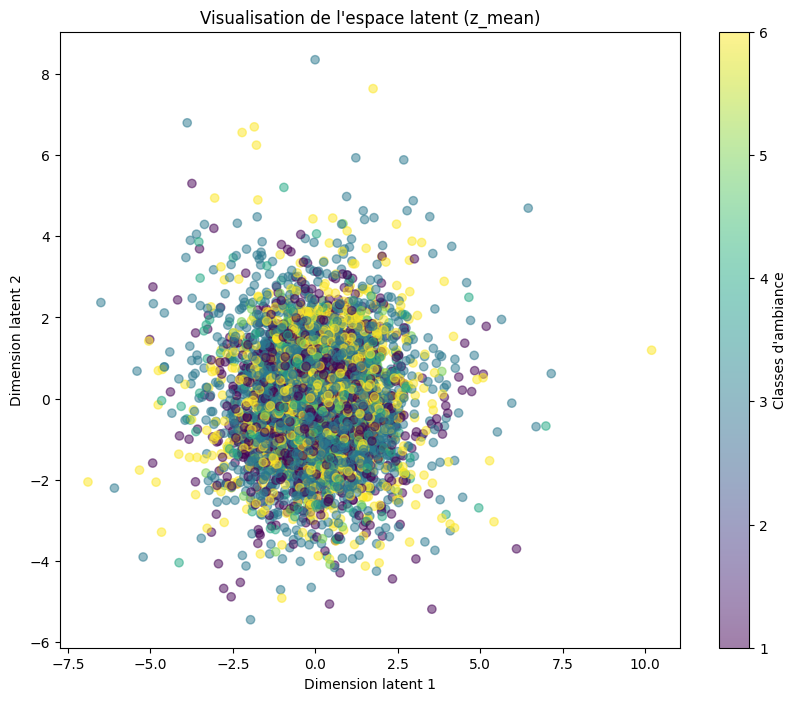

In [42]:
def afficher_espace_latent(encoder, data, labels, batch_size=32):
    # Prédire les moyennes (z_mean) dans l'espace latent
    z_mean, _, _ = encoder.predict([data, labels], batch_size=batch_size)

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(z_mean[:, 0], z_mean[:, 1], c=np.argmax(labels, axis=1), cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label="Classes d'ambiance")
    plt.xlabel("Dimension latent 1")
    plt.ylabel("Dimension latent 2")
    plt.title("Visualisation de l'espace latent (z_mean)")
    plt.show()

# Collecter toutes les images et tous les labels du dataset
images_for_latent_space = []
labels_for_latent_space = []
for batch_images, batch_labels in train_dataset:
    images_for_latent_space.append(batch_images)
    labels_for_latent_space.append(batch_labels)

images_for_latent_space = tf.concat(images_for_latent_space, axis=0)
labels_for_latent_space = tf.concat(labels_for_latent_space, axis=0)

# Appeler la fonction avec les tensors collectés
afficher_espace_latent(encoder, images_for_latent_space, labels_for_latent_space)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step


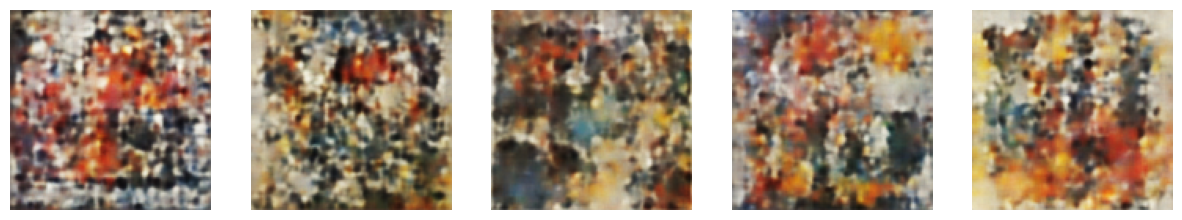

In [43]:
def generer(cvae, ambiance, n=5):
    idx = class_names.index(ambiance)
    labels = np.zeros((n, NUM_CLASSES))
    labels[:, idx] = 1

    z = np.random.normal(size=(n, LATENT_DIM))
    imgs = cvae.decoder.predict([z, labels])

    plt.figure(figsize=(n*3, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

generer(cvae, "Chaud", 5)

In [44]:
# Encodeur
cvae.encoder.save("cvae_encoder.keras")
# Décodeur
cvae.decoder.save("cvae_decoder.keras")

In [47]:
import imageio

def create_gif(ambiance_name, steps=300):
    if ambiance_name not in class_names: return

    idx = class_names.index(ambiance_name)
    label_vec = np.zeros((1, NUM_CLASSES))
    label_vec[:, idx] = 1

    # Deux points dans l'espace latent
    z1 = np.random.normal(size=(1, LATENT_DIM))
    z2 = np.random.normal(size=(1, LATENT_DIM))

    images = []

    for alpha in np.linspace(0, 1, steps):
        # Interpolation linéaire sphérique ou simple linéaire
        z_interp = z1 * (1 - alpha) + z2 * alpha
        img = cvae.decoder.predict([z_interp, label_vec], verbose=0)[0]

        # Convertir en uint8 (0-255)
        img_uint8 = (img * 255).astype(np.uint8)
        images.append(img_uint8)

    # Sauvegarde
    filename = f"interpolation_{ambiance_name}.gif"
    imageio.mimsave(filename, images, fps=30)
    print(f"GIF sauvegardé : {filename}")

# Créer le GIF
create_gif(class_names[2])

GIF sauvegardé : interpolation_Froid.gif
